# Sentiment Analysis — ML with Regresion and Naive Bayes

### 🔹 0) Setup & Mount Drive

In [1]:

# !pip install -q pandas scikit-learn matplotlib joblib nltk Sastrawi

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### 🔹 1) Import & Konfigurasi

In [2]:
import os, re, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import joblib

import nltk
from nltk.corpus import stopwords
!pip install Sastrawi -q
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Pastikan stopwords Indonesia tersedia
try:
    _ = stopwords.words("indonesian")
except LookupError:
    nltk.download("stopwords")

stop_words = set(stopwords.words("indonesian"))
stemmer = StemmerFactory().create_stemmer()

# Path & output
CSV_PATH = "/content/drive/My Drive/Proyek/Data/tweet.csv"  # ganti kalau perlu
OUTPUT_DIR = "/content/sentiment_outputs_no_tuning"
DRIVE_EXPORT_DIR = "/content/drive/My Drive/AFI/Assigment/Sentiment"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DRIVE_EXPORT_DIR, exist_ok=True)

print("CSV_PATH:", CSV_PATH)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.3 MB/s eta 0:00:00
CSV_PATH: /content/drive/My Drive/Proyek/Data/tweet.csv


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 🔹 2) Muat Data

In [3]:

df = pd.read_csv(CSV_PATH)
TEXT_COL, LABEL_COL = "tweet", "sentimen"
assert TEXT_COL in df.columns and LABEL_COL in df.columns, "Kolom 'tweet' & 'sentimen' wajib ada."

df = df[[TEXT_COL, LABEL_COL]].dropna().reset_index(drop=True)
print("Jumlah baris:", len(df))
df.head()


Jumlah baris: 1815


,tweet,sentimen
0,Kata @prabowo Indonesia tidak dihargai bangsa ...,negatif
1,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",netral
2,"Di era Jokowi, ekonomi Indonesia semakin baik....",netral
3,"Bagi Sumatera Selatan, Asian Games berdampak p...",positif
4,Negara kita ngutang buat bngun infrastruktur y...,negatif


### 🔹 3) Preprocessing (Text Cleaning)

In [4]:

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)  # URL
    text = re.sub(r"@\w+|#\w+", " ", text)                 # mention & hashtag
    text = re.sub(r"[^a-zA-Z\s]", " ", text)                # non-huruf
    tokens = text.split()
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df["clean_tweet"] = df[TEXT_COL].apply(clean_text)
df[["clean_tweet", LABEL_COL]].head()


,clean_tweet,sentimen
0,indonesia harga bangsa asing berita hoax buat ...,negatif
1,batu langka tasbih jokowi hadiah habib luthfi ...,netral
2,era jokowi ekonomi indonesia pic twitter com w...,netral
3,sumatera selatan asi games dampak pd ekonomi l...,positif
4,negara ngutang bngun infrastruktur udah dipake...,negatif


### 🔹 4) Split & TF-IDF

In [5]:

X, y = df["clean_tweet"], df[LABEL_COL]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape


((1452, 10000), (363, 10000))

### 🔹 5) Latih Model — Naive Bayes

In [6]:

nb = MultinomialNB(alpha=0.1)  # bisa coba 0.5/0.1 manual
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)

acc_nb = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb, average="macro")
print("[Naive Bayes] Accuracy:", round(acc_nb, 4), "| F1 Macro:", round(f1_nb, 4))
print(classification_report(y_test, y_pred_nb, digits=3))


[Naive Bayes] Accuracy: 0.5592 | F1 Macro: 0.5581
              precision    recall  f1-score   support

     negatif      0.565     0.588     0.576       119
      netral      0.565     0.612     0.587       121
     positif      0.546     0.480     0.511       123

    accuracy                          0.559       363
   macro avg      0.559     0.560     0.558       363
weighted avg      0.558     0.559     0.558       363



### 🔹 6) Latih Model — Logistic Regression

In [7]:

lr = LogisticRegression(max_iter=500, solver="liblinear", class_weight="balanced", C=0.1)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average="macro")
print("[Logistic Regression] Accuracy:", round(acc_lr, 4), "| F1 Macro:", round(f1_lr, 4))
print(classification_report(y_test, y_pred_lr, digits=3))


[Logistic Regression] Accuracy: 0.6116 | F1 Macro: 0.6081
              precision    recall  f1-score   support

     negatif      0.560     0.748     0.640       119
      netral      0.622     0.612     0.617       121
     positif      0.694     0.480     0.567       123

    accuracy                          0.612       363
   macro avg      0.625     0.613     0.608       363
weighted avg      0.626     0.612     0.608       363



### 🔹 7) Pilih Model Terbaik & Evaluasi Akhir

>> Best model (n): Logistic Regression | Accuracy: 0.6116 | F1 Macro: 0.6081


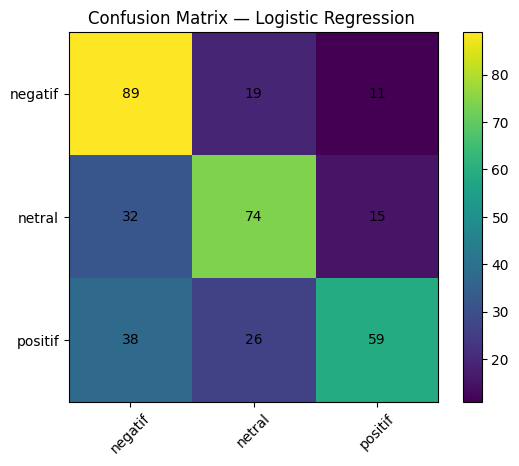

In [8]:

if f1_lr >= f1_nb:
    best_model_name = "Logistic Regression"
    best_model = lr
    y_pred = y_pred_lr
    acc, f1m = acc_lr, f1_lr
else:
    best_model_name = "Naive Bayes"
    best_model = nb
    y_pred = y_pred_nb
    acc, f1m = acc_nb, f1_nb

print(f">> Best model (n): {best_model_name} | Accuracy: {acc:.4f} | F1 Macro: {f1m:.4f}")

labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
plt.imshow(cm)
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
plt.title(f"Confusion Matrix — {best_model_name} ")
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.show()


### 🔹 8) Export Laporan (CSV/TXT) & Simpan Model

In [9]:

# Prediksi per-baris
pred_df = pd.DataFrame({
    "text": X_test.values,
    "true": y_test.values,
    "pred": y_pred,
    "correct": (y_pred == y_test).astype(int)
})
pred_df.to_csv(os.path.join(OUTPUT_DIR, "test_predictions.csv"), index=False)

# Ringkasan metrik
metrics_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose().reset_index().rename(columns={"index":"label"})
metrics_df.to_csv(os.path.join(OUTPUT_DIR, "metrics_overview.csv"), index=False)

# Info model
with open(os.path.join(OUTPUT_DIR, "model_info.txt"), "w") as f:
    f.write(f"Best model (no tuning): {best_model_name}\n")
    f.write(f"Test Accuracy: {acc}\n")
    f.write(f"Test F1 Macro: {f1m}\n")

# Simpan model & vectorizer
joblib.dump(best_model, os.path.join(OUTPUT_DIR, "model_best.joblib"))
joblib.dump(vectorizer, os.path.join(OUTPUT_DIR, "tfidf_vectorizer.joblib"))

os.listdir(OUTPUT_DIR)


['test_predictions.csv',
 'tfidf_vectorizer.joblib',
 'metrics_overview.csv',
 'model_best.joblib',
 'model_info.txt']

### 🔹 9) ZIP Semua Output

In [10]:

zip_path = os.path.join(OUTPUT_DIR, "sentiment_outputs_no_tuning.zip")
with zipfile.ZipFile(zip_path, "w") as zf:
    for fname in ["test_predictions.csv","metrics_overview.csv","model_info.txt",
                  "model_best.joblib","tfidf_vectorizer.joblib"]:
        fpath = os.path.join(OUTPUT_DIR, fname)
        if os.path.exists(fpath):
            zf.write(fpath, arcname=fname)
zip_path


'/content/sentiment_outputs_no_tuning/sentiment_outputs_no_tuning.zip'

### 🔹 10) Salin ke Google Drive & Download Langsung

In [11]:

from google.colab import files

drive_zip_path = os.path.join(DRIVE_EXPORT_DIR, "sentiment_outputs_no_tuning.zip")
!cp "{zip_path}" "{drive_zip_path}"
print("ZIP tersimpan di Drive:", drive_zip_path)

files.download(zip_path)  # unduh ke komputer


ZIP tersimpan di Drive: /content/drive/My Drive/AFI/Assigment/Sentiment/sentiment_outputs_no_tuning.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>